In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, IterableDataset

from torchvision.datasets import MNIST,CIFAR10
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

## Data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_dataset, valid_dataset = random_split(dataset, [int(len(dataset) * 0.83), int(len(dataset) * 0.17)])

## Network

In [5]:
def toy_net():
    return nn.Sequential(
        nn.Conv2d(1, 20, 7),
        nn.ReLU(),
        nn.Conv2d(20, 40, 7),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(2560, 10)
    )
toy_net()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(7, 7), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2560, out_features=10, bias=True)
)

## Server-Clients configuration

In [6]:
# underlying module must be of the same class in server & clients
server = Server(toy_net().to(device))
N = 8 # number of clients
partition = partition_by_class(train_dataset)

# for even (iid) split -> set alpha to very big value like 10e8 or very small like 10e-8
# here alpha=0.1 creates very uneven (non-iid) splits
clients = [Client(i,d,toy_net().to(device)) for i,d in enumerate(split(partition,N,alpha=0.1),start=1)]

In [7]:
def run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []
    for i in range(rounds):
        print(f'Start Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
                    #train(device, state_dict, epochs, batch_size, opt, lr, **kwargs)
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        dev_loss, dev_acc = evaluate(server.net,valid_loader)
        
        print(f'''After round {i+1} :
        - training loss = {train_loss:.4f}
        - training accuracy = {train_acc:.4f}
        - validation loss = {dev_loss:.4f}
        - validation accuracy = {dev_acc:.4f}
        ''')
        
        history.append((train_loss, dev_loss))
    return history

## SGD

In [8]:
rounds = 10
batch_size = 128
epochs = 3
lr = 1e-3

Start Round 1 ...
1: Loss = 0.2747, Accuracy = 0.9156
2: Loss = 0.2621, Accuracy = 0.9273
3: Loss = 0.1790, Accuracy = 0.9452
4: Loss = 0.2736, Accuracy = 0.9098
5: Loss = 0.2189, Accuracy = 0.9383
6: Loss = 0.0296, Accuracy = 0.9944
7: Loss = 0.2823, Accuracy = 0.9172
8: Loss = 0.1119, Accuracy = 0.9686
After round 1 :
        - training loss = 0.8108
        - training accuracy = 0.7427
        - validation loss = 0.8151
        - validation accuracy = 0.7443
        
Start Round 2 ...
1: Loss = 0.2681, Accuracy = 0.9175
2: Loss = 0.2554, Accuracy = 0.9276
3: Loss = 0.1725, Accuracy = 0.9463
4: Loss = 0.2665, Accuracy = 0.9136
5: Loss = 0.2131, Accuracy = 0.9379
6: Loss = 0.0279, Accuracy = 0.9947
7: Loss = 0.2774, Accuracy = 0.9172
8: Loss = 0.1065, Accuracy = 0.9686
After round 2 :
        - training loss = 0.7610
        - training accuracy = 0.7561
        - validation loss = 0.7633
        - validation accuracy = 0.7567
        
Start Round 3 ...
1: Loss = 0.2616, Accuracy = 0.9

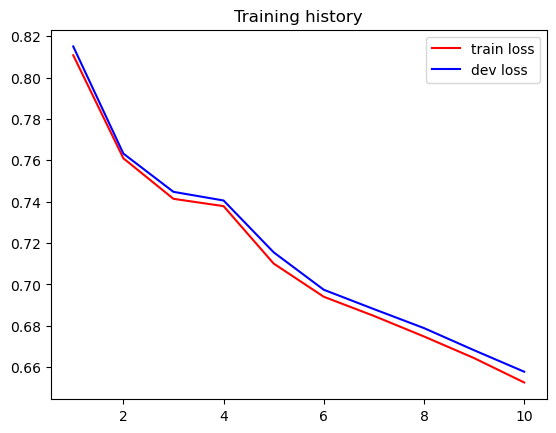

In [13]:
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.SGD,lr)
plot_loss_epoch(history)

## Adagrad

In [ ]:
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.Adagrad,lr)
plot_loss_epoch(history)

Start Round 1 ...
1: Loss = 0.1992, Accuracy = 0.9366
2: Loss = 0.1874, Accuracy = 0.9422
3: Loss = 0.1114, Accuracy = 0.9644
4: Loss = 0.1933, Accuracy = 0.9318
5: Loss = 0.1431, Accuracy = 0.9562
6: Loss = 0.0158, Accuracy = 0.9967
7: Loss = 0.1789, Accuracy = 0.9475
8: Loss = 0.0729, Accuracy = 0.9776
After round 1 :
        - training loss = 0.7598
        - training accuracy = 0.7661
        - validation loss = 0.7611
        - validation accuracy = 0.7674
        
Start Round 2 ...
1: Loss = 0.1725, Accuracy = 0.9464
2: Loss = 0.1528, Accuracy = 0.9527
3: Loss = 0.0905, Accuracy = 0.9712
4: Loss = 0.1566, Accuracy = 0.9446
5: Loss = 0.1151, Accuracy = 0.9660
6: Loss = 0.0122, Accuracy = 0.9972
7: Loss = 0.1514, Accuracy = 0.9566
8: Loss = 0.0671, Accuracy = 0.9789
After round 2 :
        - training loss = 0.6852
        - training accuracy = 0.7839
        - validation loss = 0.6897
        - validation accuracy = 0.7856
        
Start Round 3 ...
1: Loss = 0.1367, Accuracy = 0.9